In [79]:
library(ggraph)
library(igraph)
library(RCurl)

Loading required package: ggplot2

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: bitops


# 1. Preferance relation construction

## 1.1. Code

In [109]:
# Input: performanceMatrix
#strength of the concordant coalition
Criterion <- function(weight, type="max", pa=0, pb=0, qa=0, qb=0, va=0, vb=0) {
    q <- function (value) qa*value + qb
    p <- function (value) pa*value + pb
    v <- function (value) va*value + vb
    
    return(list(
        weight = weight,
        gain = type=="max",
        q = q,
        p = p,
        v = v
    ))
}

concordance_test <- function(alternative, comparedAlternative, criterion) {
    indifference_treshhold <- criterion$q(alternative)
    preference_treshhold <- criterion$p(alternative)
    difference <- alternative - comparedAlternative
    
    if (criterion$gain == TRUE) {
        difference <- -1 * difference
    }
    
    if (indifference_treshhold > difference) {
        return(1)
    }
    
    if (preference_treshhold < difference) {
        return(0)
    }
    (preference_treshhold - difference) / (preference_treshhold - indifference_treshhold)
    
}

discordance_test <- function(alternative, comparedAlternative, criterion) {
    veto_treshhold <- criterion$v(alternative)
    difference <- alternative - comparedAlternative
    
    if (criterion$gain == TRUE) {
        difference <- -1 * difference
    }
    
    if (difference > veto_treshhold) {
        return(TRUE)
    }
    return(FALSE)
}

In [209]:
calculatePartialConcordanceCoefficients <- function(
    performanceTable,
    criteria
) {
    partialConcordanceCoefficientsCube <- array(
        0, 
        dim=c(
            nrow(performanceTable),
            nrow(performanceTable),
            ncol(performanceTable)
        ),
        dimnames = list(
            rownames(performanceTable),
            rownames(performanceTable),
            colnames(performanceTable)
        )
    )
    
    for (c in seq(ncol(performanceTable))) {
        criterion <- criteria[[c]]

        for (i in seq(nrow(performanceTable))) {
            for (j in seq(nrow(performanceTable))) {
                if (i == j) next
                partialConcordanceCoefficientsCube[i, j, c] <- 
                    concordance_test(performanceTable[i, c], performanceTable[j, c], criterion)                    
            }
        }
    }
    return(partialConcordanceCoefficientsCube)
}


calculateConcordanceCoefficients <- function(partialConcordanceCoefficientsCube, criteriaWeights) {
    criteriaWeightsSum <- sum(criteriaWeights)

    apply(partialConcordanceCoefficientsCube, c(1, 2), function(partialConcordanceCoefficient) {
        sum(partialConcordanceCoefficient*criteriaWeights) / criteriaWeightsSum
    })
}


calculateVetoMatrix <- function(performanceTable, criteria) {
    vetoMatrix <- array(
        FALSE, 
        dim=c(
            nrow(performanceTable),
            nrow(performanceTable)
        ),
        dimnames = list(
            rownames(performanceTable),
            rownames(performanceTable)
        )
    )

    for (i in seq(nrow(performanceTable))) {
        for (j in seq(nrow(performanceTable))) {
            if (i == j) next
            veto_threshold_reached <- sapply(
                seq(length(criteria)),
                function(idx) discordance_test(performanceTable[i, idx], performanceTable[j, idx], criteria[[idx]]))
            vetoMatrix[i, j] <- any(veto_threshold_reached)
        }
    }

    return(vetoMatrix)
}


## 1.2 Tests 

In [110]:
alternatives <- c("A1", "A2", "A3", "A4", "A5", "A6", "A7", "A8", "A9", "A10")
criteriaName <- c("C1", "C2", "C3", "C4", "C5", "C6", "C7")
lambda = 0.5

performanceMatrix <- matrix(c(
    20, 20, 0 , 0 , 10, 10, 10,
    5 , 5 , 5 , 5 , 5 , 5 , 5 ,
    40, 0 , 0 , 30, 10, 15, 15,
    15, 15, 10, 0 , 40, 5 , 0 ,
    10, 10, 10, 5 , 5 , 5 , 5 ,
    10, 10, 10, 10, 30, 0 , 20,
    5 , 5 , 5 , 10, 10, 10, 10,
    15, 10, 10, 5 , 15, 20, 0 ,
    20, 10, 0 , 10, 15, 5 , 5 ,
    80, 0 , 0 , 0 , 0 , 0 , 0 
), nrow=10, dimnames=list(alternatives, criteriaName), byrow=TRUE)
performanceMatrix

criteria <- list(
    Criterion(1, "max", qb=5, pb=15, vb=30),
    Criterion(1, "max", qb=5, pb=15, vb=30),
    Criterion(1, "min", qb=5, pb=15, vb=30),
    Criterion(1, "min", qb=5, pb=15, vb=30),
    Criterion(1, "max", qb=5, pb=15, vb=30),
    Criterion(1, "min", qb=5, pb=15, vb=30),
    Criterion(1, "min", qb=5, pb=15, vb=30)
)

concorndanceCoefficients <- calculateConcordanceCoefficients(
    calculatePartialConcordanceCoefficients(performanceMatrix, criteria),
    sapply(criteria, function(criterion) criterion$weight)
)
vetoMatrix <- calculateVetoMatrix(performanceMatrix, criteria)
    
preferenceRelation <- concorndanceCoefficients > lambda

preferenceRelation <- preferenceRelation & !vetoMatrix

,C1,C2,C3,C4,C5,C6,C7
A1,20,20,0,0,10,10,10
A2,5,5,5,5,5,5,5
A3,40,0,0,30,10,15,15
A4,15,15,10,0,40,5,0
A5,10,10,10,5,5,5,5
A6,10,10,10,10,30,0,20
A7,5,5,5,10,10,10,10
A8,15,10,10,5,15,20,0
A9,20,10,0,10,15,5,5
A10,80,0,0,0,0,0,0


# 2. Graph - cycle removal and kernel finding

## 2.1 Code

In [71]:
traverse_deep <- function(node, nodes_dependants, path, cycles) {
    current_path <- append(path, node)
    if (length(nodes_dependants[[node]]) == 0) {
        return(list(nodes_dependants, cycles))
    }
    
    updated_nodes_dependants <- nodes_dependants
    updated_cycles <- cycles
    
    
    for (successor_idx in seq(1:length(updated_nodes_dependants[[node]]))) {
        
        updated_nodes_dependants[[node]][[successor_idx]]$traversed <- TRUE
        successor <- updated_nodes_dependants[[node]][[successor_idx]]

        if (successor$idx %in% current_path) {
            updated_cycles[[length(updated_cycles)+1]] <- 
                unlist(current_path[match(successor$idx, current_path):length(current_path)])
            next  
        }
        new_data <- traverse_deep(successor$idx, updated_nodes_dependants, current_path, updated_cycles)
        updated_nodes_dependants <- new_data[[1]]
        updated_cycles <- new_data[[2]]
    }
    return(list(updated_nodes_dependants, updated_cycles))
}

find_cicles <- function(adjacency_matrix) {
    nodes_dependants <- list()

    for (row_idx in seq(1, nrow(adjacency_matrix))) {
        row <- adjacency_matrix[row_idx, ]
        dependants <- Filter(function (idx) { row[idx] == 1 }, seq(1, length(row)))
        nodes_dependants[[row_idx]] <- sapply(dependants, function (idx) { 
            a <- list(list(idx=idx, traversed=FALSE))
            return(a)
        })
       
    }
    
    start_node <- 0
    cycles <- list()
    while (any(unlist(nodes_dependants) == FALSE) && start_node < length(nodes_dependants)) {
        start_node <- start_node + 1
        if (all(unlist(nodes_dependants[start_node])) == TRUE) {
            next
        }
        current_path <- list(start_node)
        for (node_idx in seq(1:length(nodes_dependants[[start_node]]))) {
            nodes_dependants[[start_node]][[node_idx]]$traversed <- TRUE
            node <- nodes_dependants[[start_node]][[node_idx]]
            
            result <- traverse_deep(node$idx, nodes_dependants, current_path, cycles)
            cycles <- result[[2]]
            nodes_dependants <- result[[1]]
        }
    }

    cycles <- Map(sort, cycles)
    cycles <- Map(as.integer, cycles)

    return(cycles[!duplicated(cycles)])
}


In [72]:
aggregate <- function(adjacency_matrix, vertices_to_squash, name="Agg1") {
    squashed_rows <- adjacency_matrix[vertices_to_squash, -vertices_to_squash]
    squashed_cols <- adjacency_matrix[-vertices_to_squash, vertices_to_squash]
    reminder_matrix <- adjacency_matrix[-vertices_to_squash, -vertices_to_squash]
    
    squashed_rows <- append(apply(squashed_rows, 2, function(col) { min(sum(col), 1)}), 0)
    squashed_cols <- apply(squashed_cols, 1, function(row) { min(sum(row), 1)})
    
    reminder_matrix <- cbind(reminder_matrix, squashed_cols)
    reminder_matrix <- rbind(reminder_matrix, squashed_rows)
    
    rn <- rownames(reminder_matrix)
    rn[nrow(reminder_matrix)] <- paste(rownames(adjacency_matrix)[vertices_to_squash], collapse='_')
    rownames(reminder_matrix) <- rn
    colnames(reminder_matrix) <- rn
    
    reminder_matrix
}

In [73]:
remove_cycles <- function(adjacency_matrix) {
    processed_matrix <- adjacency_matrix
    cycles <- find_cicles(processed_matrix)

    while (length(cycles) > 0) {
        shortest <- cycles[which.min(Map(length, cycles))][[1]]
        processed_matrix <- aggregate(processed_matrix, shortest)

        cycles <- find_cicles(processed_matrix)
    }
    processed_matrix
}

In [203]:
get_predecessors <- function(adjacency_matrix) {
    predecessors <- list()
    for (col_idx in seq(1, ncol(adjacency_matrix))) {
        vertex_pred <- rownames(adjacency_matrix)[adjacency_matrix[,col_idx] == 1]
        predecessors[[col_idx]] <- vertex_pred        
    }
    
    return(predecessors)
}

all_marked <- function(data_frame) {
    all(data_frame$status == 'Y' | data_frame$status == 'N')
}

remove_predecessors <- function (predecessors, to_remove) {
    if (length(predecessors)) {
        should_be_removed <- as.logical(!(predecessors %in% to_remove))

        if (any(should_be_removed)) {
            return(predecessors[should_be_removed])
        }
    }
    return(list())
}


find_kernel <- function(adjacency_matrix) {
    predecessors <- get_predecessors(adjacency_matrix)
    data_frame <- data.frame(
        vertex_name=rownames(adjacency_matrix),
        predecessors=I(predecessors),
        status='',
        stringsAsFactors = FALSE
    )

    iterations <- 0
    while(!all_marked(data_frame) && iterations <= nrow(data_frame)) {
        to_remove <- list()

        for (row_idx in seq(1, nrow(data_frame))) {
            row <- data_frame[row_idx,]
            predecessors <- row$predecessors[[1]]
            
            if (row$status != '') next
            if (length(predecessors) == 0) {
                data_frame[row_idx,]$status <- 'Y'
            }
            else {
                in_kernel <- data_frame[data_frame$status == 'Y',]$vertex_name
                if (any(in_kernel %in% predecessors)) {
                    data_frame[row_idx,]$status <- 'N'
                    to_remove <- append(to_remove, row$vertex_name)
                }
            }
        }
        for (row_idx in seq(1, nrow(data_frame))) {
            predecessors <- data_frame[row_idx,]$predecessors[[1]]
            
            data_frame[row_idx,]$predecessors[[1]] <-
                remove_predecessors(predecessors, to_remove)
        }
        iterations <- iterations + 1
        print(data_frame)
    }
    if (iterations > nrow(data_frame)) stop("Maximum number iteration exeded finding kernel")
    return(data_frame[data_frame$status == 'Y',]$vertex_name)
}


## 2.2. Tests

In [75]:
print_graph <- function(adjacency_matrix) {
    graph <- graph_from_adjacency_matrix(adjacency_matrix, mode=list("directed"))
    arrow_g <- arrow(angle = 30, length = unit(0.15, 'inches'), ends = 'last', type = 'closed')

    ggraph(graph, layout = 'kk') +
      geom_edge_link(
          colour = 'palegreen4',
          arrow = arrow_g,
          end_cap = circle(0.1, 'inches')) + 
      geom_node_circle(aes(r=0.15), size=0) + 
      geom_node_label(aes(label=rownames(adjacency_matrix)), size=5, fill='azure2', label.size=0) +
      theme_void() + theme(legend.position="none", plot.title=element_text(size=30, hjust=0.5))
}

In [178]:
alternatives <- c("A1", "A2", "A3", "A4", "A5", "A6", "A7", "A8", "A9", "A10")

mat1 <- matrix(c(
   0,  1,  0,  1,  1, 1, 1, 1, 1,   0,
   0,  0,  0,  0,  0, 0, 1, 0, 0,   0,
   1,  1,  0,  1,  1,  1, 1, 1, 1,   0,
   0,  1,  0,  0,  1,  1, 1, 1, 0,   0,
   0,  1,  0,  0,  0,  1, 1, 0, 0,   0,
   0,  1,  0,  0,  1,  0, 1, 0, 0,   0,
   0,  1,  0,  0,  0,  0, 0, 0, 0,  0,
   0,  1,  0,  1,  1,  1, 1, 0, 0,  0,
   1,  1,  0, 1,  1,  1, 1, 1, 0,   0,
   1,  1,  1, 0,  1,  1, 1, 1, 1,   0
), nrow=10, dimnames=list(alternatives, alternatives), byrow=TRUE)
print(mat1)

    A1 A2 A3 A4 A5 A6 A7 A8 A9 A10
A1   0  1  0  1  1  1  1  1  1   0
A2   0  0  0  0  0  0  1  0  0   0
A3   1  1  0  1  1  1  1  1  1   0
A4   0  1  0  0  1  1  1  1  0   0
A5   0  1  0  0  0  1  1  0  0   0
A6   0  1  0  0  1  0  1  0  0   0
A7   0  1  0  0  0  0  0  0  0   0
A8   0  1  0  1  1  1  1  0  0   0
A9   1  1  0  1  1  1  1  1  0   0
A10  1  1  1  0  1  1  1  1  1   0


In [204]:
processed_matrix <- remove_cycles(mat1)
find_kernel(processed_matrix)


  vertex_name predecessors status
1          A3          A10       
2         A10                   Y
3       A2_A7      A3, A10      N
4       A5_A6      A3, A10      N
5       A4_A8      A3, A10      N
6       A1_A9      A3, A10      N
  vertex_name predecessors status
1          A3          A10      N
2         A10                   Y
3       A2_A7          A10      N
4       A5_A6          A10      N
5       A4_A8          A10      N
6       A1_A9          A10      N


[1] "A10"

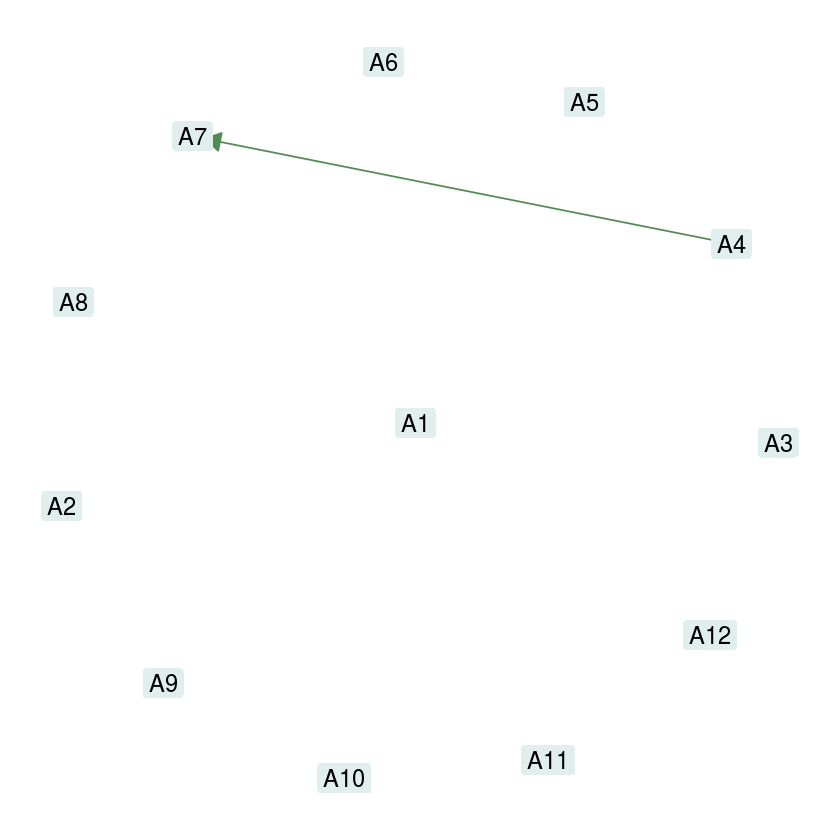

In [97]:
print_graph(mat1)

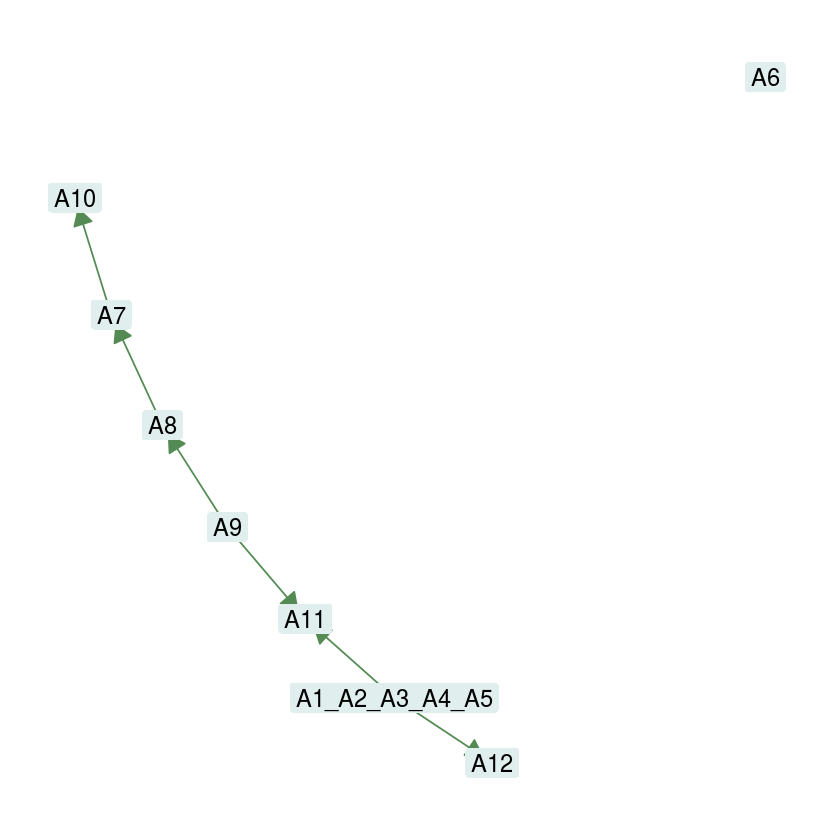

In [450]:
print_graph(processed_matrix)

# 3. Joint solution

## 3.1. Code

In [212]:
ElectreI <- function(performanceTable, criteria, lamda=0.5) {
    concorndanceCoefficients <- calculateConcordanceCoefficients(
        calculatePartialConcordanceCoefficients(performanceMatrix, criteria),
        sapply(criteria, function(criterion) criterion$weight)
    )
    preferenceRelation <- (concorndanceCoefficients > lambda) & (!calculateVetoMatrix(performanceMatrix, criteria))

    graphAdjacencyMatrix <- preferenceRelation * 1
    
    acyclicAdjacencyMatrix <- remove_cycles(graphAdjacencyMatrix)
        
     kernel <- find_kernel(acyclicAdjacencyMatrix)
        
    return(list(
         kernel=kernel,
        acyclicGraph=acyclicAdjacencyMatrix,
        graph=graphAdjacencyMatrix,
        preferenceRelation=preferenceRelation
    ))
}

## 3.2 Test

  vertex_name predecessors status
1          A7 A8, A9, ....       
2          A8 A9, A4_A....       
3          A9  A4_A1_A3_A6       
4         A10                   Y
5       A2_A5 A7, A8, ....       
6 A4_A1_A3_A6                   Y
  vertex_name predecessors status
1          A7  A4_A1_A3_A6      N
2          A8  A4_A1_A3_A6      N
3          A9  A4_A1_A3_A6      N
4         A10                   Y
5       A2_A5  A4_A1_A3_A6      N
6 A4_A1_A3_A6                   Y
       A1    A2    A3    A4    A5    A6    A7    A8    A9   A10
A1  FALSE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE
A2  FALSE FALSE FALSE FALSE  TRUE FALSE FALSE FALSE FALSE FALSE
A3   TRUE  TRUE FALSE FALSE  TRUE FALSE  TRUE FALSE FALSE FALSE
A4  FALSE  TRUE FALSE FALSE  TRUE  TRUE FALSE  TRUE FALSE FALSE
A5  FALSE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
A6  FALSE  TRUE  TRUE FALSE  TRUE FALSE  TRUE  TRUE  TRUE FALSE
A7  FALSE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
A8  FALSE  T

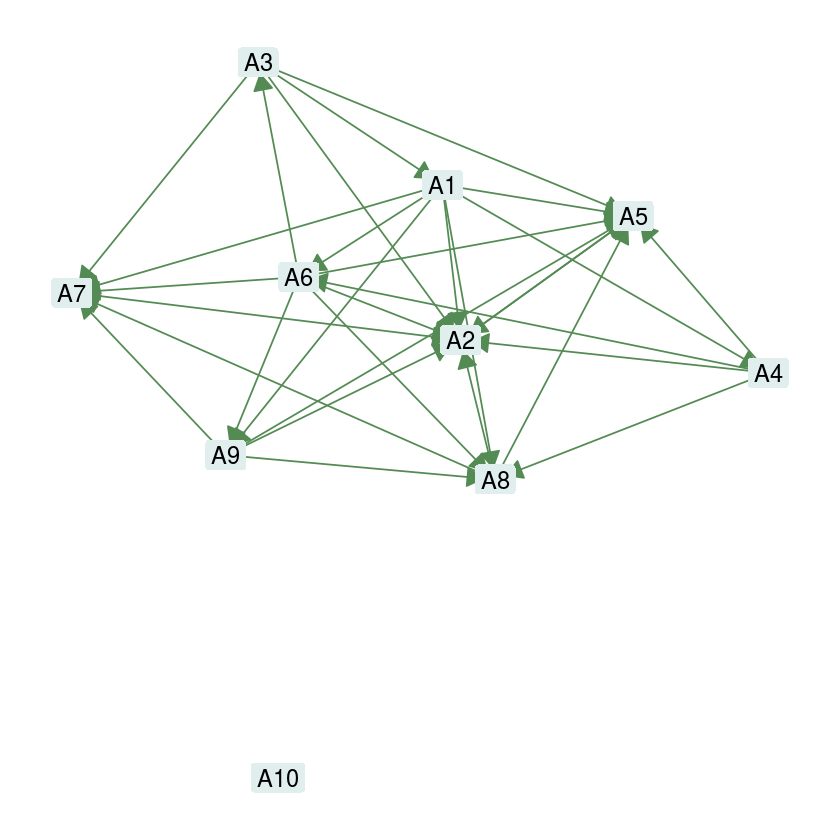

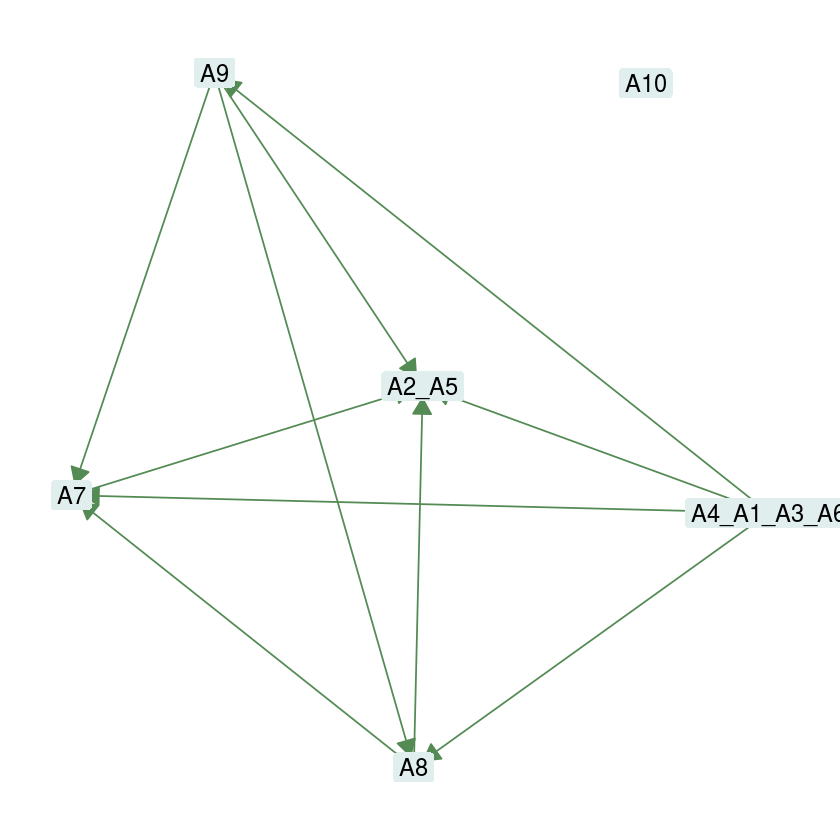

In [215]:
alternatives <- c("A1", "A2", "A3", "A4", "A5", "A6", "A7", "A8", "A9", "A10")
criteriaName <- c("C1", "C2", "C3", "C4", "C5", "C6", "C7")
lambda = 0.7

performanceMatrix <- matrix(c(
    20, 20, 0 , 0 , 10, 10, 10,
    5 , 5 , 5 , 5 , 5 , 5 , 5 ,
    40, 0 , 0 , 30, 10, 15, 15,
    15, 15, 10, 0 , 40, 5 , 0 ,
    10, 10, 10, 5 , 5 , 5 , 5 ,
    10, 10, 0, 0, 30, 0 , 20,
    5 , 5 , 5 , 10, 10, 10, 10,
    15, 10, 10, 5 , 15, 20, 0 ,
    20, 10, 0 , 10, 15, 5 , 5 ,
    80, 0 , 0 , 0 , 0 , 0 , 0 
), nrow=10, dimnames=list(alternatives, criteriaName), byrow=TRUE)


criteria <- list(
    Criterion(1, "max", qb=0, pb=7, vb=30),
    Criterion(1, "max", qb=0, pb=7, vb=30),
    Criterion(1, "min", qb=0, pb=7, vb=30),
    Criterion(1, "min", qb=0, pb=7, vb=30),
    Criterion(1, "max", qb=0, pb=7, vb=30),
    Criterion(1, "max", qb=0, pb=7, vb=30),
    Criterion(1, "max", qb=0, pb=7, vb=30)
)


result = ElectreI(performanceTable, criteria, lambda)
print(result$preferenceRelation)
print(result$kernel)
print_graph(result$graph)
print_graph(result$acyclicGraph)